# Running inference tools

This is a rendered copy of [ml_tools.ipynb](https://github.com/scikit-hep/coffea/blob/master/binder/ml_tools.ipynb). You can optionally run it interactively on [binder at this link](https://mybinder.org/v2/gh/coffeateam/coffea/master?filepath=binder%2Fml_tools.ipynb)

As machine learning (ML) becomes more popular in HEP analysis, `coffea` also
provide tools to assist with using ML tools within the `coffea` framework. For
training and validation, you would likely need custom data mangling tools to
convert HEP data formats ([NanoAOD][nanoaod], [PFNano][pfnano]) to a format that
best interfaces with the ML tool of choice, as for training and validation, you
typical want to have fine control over what computation is done. For more
advanced use cases of data mangling and data saving, refer to the [awkward array
manual][datamangle] and [uproot][uproot_write]/[parquet][ak_parquet] write
operations for saving intermediate states. The helper tools provided in coffea
focuses on ML inference, where ML tool outputs are used as another variable to
be used in the event/object selection chain.

[nanoaod]: https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD
[pfnano]: https://github.com/cms-jet/PFNano
[datamangle]: https://awkward-array.org/doc/main/user-guide/how-to-restructure.html
[uproot_write]: https://uproot.readthedocs.io/en/latest/basic.html#writing-ttrees-to-a-file
[ak_parquet]: https://awkward-array.org/doc/main/reference/generated/ak.to_parquet.html


## Why these wrapper tools are needed

### Warning: This notebook is only relevant if you are using coffea in "dask" mode with dask-awkward

The typical operation of using ML inference tools in the awkward/coffea analysis
tools involves the conversion and padding of awkward array to ML tool containers
(usually something that is `numpy`-compatible), run the inference, then
convert-and-truncate back into the awkward array syntax required for the
analysis chain to continue. With awkward arrays' laziness now being handled
entirely by [`dask`][dask_awkward], the conversion operation of awkward array to
other array types needs to be wrapped in a way that is understandable to `dask`.
The packages in the `ml_tools` package attempts to wrap the common tools used by
the HEP community with a common interface to reduce the verbosity of the code on
the analysis side.

[dask_awkward]: https://dask-awkward.readthedocs.io/en/stable/gs-limitations.html


## Example using ParticleNet-like jet variable calculation using PyTorch (GNN)

The example given in this notebook be using [`pytorch`][pytorch] to calculate a
jet-level discriminant using its constituent particles. An example for how to
construct such a `pytorch` network can be found in the docs file, but for
`mltools` in coffea, we only support the [TorchScript][pytorch] format files to
load models to ensure operability when scaling to clusters. Let us first start
by downloading the example ParticleNet model file and a small `PFNano`
compatible file, and a simple function to open the `PFNano` with and without
dask.

[pytorch]: https://pytorch.org/
[pytorch_jit]: https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format


In [1]:
!wget --quiet -O model.pt https://github.com/scikit-hep/coffea/raw/master/tests/samples/triton_models_test/pn_test/1/model.pt
!wget --quiet -O pfnano.root https://github.com/scikit-hep/coffea/raw/master/tests/samples/pfnano.root

In [2]:
from coffea.nanoevents import NanoEventsFactory
from coffea.nanoevents.schemas import PFNanoAODSchema


def open_events():
    factory = NanoEventsFactory.from_root(
        {"file:./pfnano.root": "Events"},
        schemaclass=PFNanoAODSchema,
        mode="dask",
    )
    return factory.events()

Now we prepare a class to handle inference request by extending the
`mltools.torch_wrapper` class. As the base class cannot know anything about the
data mangling required for the users particular model, we will need to overload
at least the method `prepare_awkward`:

- The input can be an arbitrary number of awkward arrays or dask awkward array
  (but never a mix of dask/non-dask array). In this example, we will be passing
  in the event array.
- The output should be single tuple `a` + single dictionary `b`, this is to
  ensure that arbitrarily complicated outputs can be passed to the underlying
  `pytorch` model instance like `model(*a, **b)`. The contents of `a` and `b`
  should be `numpy`-compatible awkward-like arrays: if the inputs are non-dask
  awkward arrays, the return should also be non-dask awkward arrays that can be
  trivially converted to `numpy` arrays via a `ak.to_numpy` call; if the inputs
  are dask awkward arrays, the return should be still be dask awkward arrays
  that can be trivially converted via a `to_awkward().to_numpy()` call.

  In this ParticleNet-like example, the model expects the following inputs:

  - A `N` jets x `2` coordinate x `100` constituents "points" array,
    representing the constituent coordinates.
  - A `N` jets x `5` feature x `100` constituents "features" array, representing
    the constituent features of interest to be used for inference.
  - A `N` jets x `1` mask x `100` constituent "mask" array, representing whether
    a constituent should be masked from the inference request.

  In this case, we will need to flatten the `E` events x `N` jets structure,
  then, we will need to stack the constituent attributes of interest via
  `ak.concatenate` into a single array.

After defining this minimum class, we can attempt to run inference using the
`__call__` method defined in the base class.


In [3]:
from coffea.ml_tools.torch_wrapper import torch_wrapper
import awkward as ak
import dask_awkward
import numpy as np


class ParticleNetExample1(torch_wrapper):
    def prepare_awkward(self, events):
        jets = ak.flatten(events.Jet)

        def pad(arr):
            return ak.fill_none(
                ak.pad_none(arr, 100, axis=1, clip=True),
                0.0,
            )

        # Human readable version of what the inputs are
        # Each array is a N jets x 100 constituent array
        imap = {
            "points": {
                "deta": pad(jets.eta - jets.constituents.pf.eta),
                "dphi": pad(jets.delta_phi(jets.constituents.pf)),
            },
            "features": {
                "dr": pad(jets.delta_r(jets.constituents.pf)),
                "lpt": pad(np.log(jets.constituents.pf.pt)),
                "lptf": pad(np.log(jets.constituents.pf.pt / jets.pt)),
                "f1": pad(np.log(np.abs(jets.constituents.pf.d0) + 1)),
                "f2": pad(np.log(np.abs(jets.constituents.pf.dz) + 1)),
            },
            "mask": {
                "mask": pad(ak.ones_like(jets.constituents.pf.pt)),
            },
        }

        # Compacting the array elements into the desired dimension using
        # ak.concatenate
        retmap = {k: ak.concatenate([x[:, np.newaxis, :] for x in imap[k].values()], axis=1) for k in imap.keys()}

        # Returning everything using a dictionary. Also perform type conversion!
        return (), {
            "points": ak.values_astype(retmap["points"], "float32"),
            "features": ak.values_astype(retmap["features"], "float32"),
            "mask": ak.values_astype(retmap["mask"], "float16"),
        }


# Setting up the model container
pn_example1 = ParticleNetExample1("model.pt")

# Running on dask_awkward array
dask_events = open_events()
dask_results = pn_example1(dask_events)
print("Dask awkward results:", dask_results.compute())  # Runs file!

/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/ml_tools/helper.py:175: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")


Dask awkward results: [[0.0693, -0.0448], [0.0678, -0.0451], ..., [0.0616, ...], [0.0587, -0.0172]]


For each jet in the input to the `torch` model, the model returns a 2-tuple
probability value. Without additional specification, the `torch_wrapper` class
performs a trival conversion of `ak.from_numpy` of the torch model's output. We
can specify that we want to fold this back into nested structure by overloading
the `postprocess_awkward` method of the class.

For the ParticleNet example we are going perform additional computation for the
conversion back to awkward array formats:

- Calculate the `softmax` method for the return of each jet (commonly used as
  the singular ML inference "scores")
- Fold the computed `softmax` array back into nested structure that is
  compatible with the original events.Jet array.

Notice that the inputs of the `postprocess_awkward` method is different from the
`prepare_awkward` method, only by that the first argument is the return array
of the model inference after the trivial `from_numpy` conversion. Notice that
the return_array is a dask array.


In [4]:
class ParticleNetExample2(ParticleNetExample1):
    def postprocess_awkward(self, return_array, events):
        softmax = np.exp(return_array)[:, 0] / ak.sum(np.exp(return_array), axis=-1)
        njets = ak.count(events.Jet.pt, axis=-1)
        return ak.unflatten(softmax, njets)


pn_example2 = ParticleNetExample2("model.pt")

# Running on dask awkward
dask_events = open_events()
dask_jets = dask_events.Jet
dask_jets["MLresults"] = pn_example2(dask_events)
dask_events["Jet"] = dask_jets
print(dask_events.Jet.MLresults.compute())

/Users/iason/Dropbox/work/pyhep_dev/dask-awkward/src/dask_awkward/lib/structure.py:911: UserWarning: Please ensure that dask.awkward<count, type='## * int64', npartitions=1>
        is partitionwise-compatible with dask.awkward<divide, type='## * float32', npartitions=1>
        (e.g. counts comes from a dak.num(array, axis=1)),
        otherwise this unflatten operation will fail when computed!
  warnings.warn(


[[0.528, 0.528, 0.524, 0.523, 0.521, 0.52, 0.519, 0.519], ..., [0.528, ...]]


Of course, the implementation of the classes above can be written in a single
class. Here is a copy-and-paste implementation of the class with all the
functionality described in the cells above:


In [5]:
class ParticleNetExample(torch_wrapper):
    def prepare_awkward(self, events):
        jets = ak.flatten(events.Jet)

        def pad(arr):
            return ak.fill_none(
                ak.pad_none(arr, 100, axis=1, clip=True),
                0.0,
            )

        # Human readable version of what the inputs are
        # Each array is a N jets x 100 constituent array
        imap = {
            "points": {
                "deta": pad(jets.eta - jets.constituents.pf.eta),
                "dphi": pad(jets.delta_phi(jets.constituents.pf)),
            },
            "features": {
                "dr": pad(jets.delta_r(jets.constituents.pf)),
                "lpt": pad(np.log(jets.constituents.pf.pt)),
                "lptf": pad(np.log(jets.constituents.pf.pt / jets.pt)),
                "f1": pad(np.log(np.abs(jets.constituents.pf.d0) + 1)),
                "f2": pad(np.log(np.abs(jets.constituents.pf.dz) + 1)),
            },
            "mask": {
                "mask": pad(ak.ones_like(jets.constituents.pf.pt)),
            },
        }

        # Compacting the array elements into the desired dimension using
        # ak.concatenate
        retmap = {k: ak.concatenate([x[:, np.newaxis, :] for x in imap[k].values()], axis=1) for k in imap.keys()}

        # Returning everything using a dictionary. Also take care of type
        # conversion here.
        return (), {
            "points": ak.values_astype(retmap["points"], "float32"),
            "features": ak.values_astype(retmap["features"], "float32"),
            "mask": ak.values_astype(retmap["mask"], "float16"),
        }

    def postprocess_awkward(self, return_array, events):
        softmax = np.exp(return_array)[:, 0] / ak.sum(np.exp(return_array), axis=-1)
        njets = ak.count(events.Jet.pt, axis=-1)
        return ak.unflatten(softmax, njets)


pn_example = ParticleNetExample("model.pt")

# Running on dask awkward arrays
dask_events = open_events()
dask_jets = dask_events.Jet
dask_jets["MLresults"] = pn_example(dask_events)
dask_events["Jet"] = dask_jets
print(dask_events.Jet.MLresults.compute())

print(dask_awkward.necessary_columns(dask_events.Jet.MLresults))

[[0.528, 0.528, 0.524, 0.523, 0.521, 0.52, 0.519, 0.519], ..., [0.528, ...]]
{'from-uproot-58aeee0c5640af6153963389c75a2e8d': frozenset({'nJet', 'nJetPFCands', 'PFCands_pt', 'JetPFCands_pFCandsIdx', 'nPFCands', 'PFCands_phi', 'PFCands_dz', 'PFCands_eta', 'PFCands_d0', 'Jet_eta', 'Jet_pt', 'Jet_nConstituents', 'Jet_phi'})}


In particular, analyzers should check that the last line contains only the
branches required for ML inference; if there are many non-required branches,
this may lead the significant performance penalties. 

As per other dask tools, the users can extract how dask is analyzing the
processing the computation routines using the following snippet.

HighLevelGraph with 60 layers.
 0. from-uproot-58aeee0c5640af6153963389c75a2e8d
 1. JetPFCands-139400613a3d604b15fb49b4663c04c7
 2. PFCands-2493ed3f0a02809524c60023e568739c
 3. Jet-73c9633c1ebf5b7e0031ae383fe2efc8
 4. flatten-5b89765aab482bdae2662124368ab6ea
 5. pt-c3e7744a71b1e30e1d3a71850e45b4a9
 6. pFCandsIdxG-fb492c35ca6c0d4687a14252c5e48400
 7. apply-global-index-eb29f62f5031f666082928520229e13f
 8. pFCandsIdxG-f8ca8089a594f04597fdc642408849cc
 9. apply-global-index-6d74236c8771758bd85fad86fcae7fcf
 10. dz-3d7f8da5608835eee3fa22030e1988d8
 11. absolute-5850609e99300a095483d5b960e0983c
 12. add-76cc2f7e86fb21c164a045d671139ddc
 13. log-a249f8b7766fe087a41bb2f1372eda31
 14. pad-none-3bdcaaf5b77e4067d319ea7b5e63d95e
 15. fill-none-bdcde320b3b9d32b819c29c00e62c1f3
 16. getitem-e600c21dba53b11e46ec64c971beab39
 17. d0-b85066cc4306a0bd8bd4c1915ea47fcf
 18. absolute-255d140ec82285e21817cdeabf7ece00
 19. add-6e72ef2d25a889376dab14aefcea0b51
 20. log-210b4f3b6d45ea684b3b7dc6963e0194
 21. p

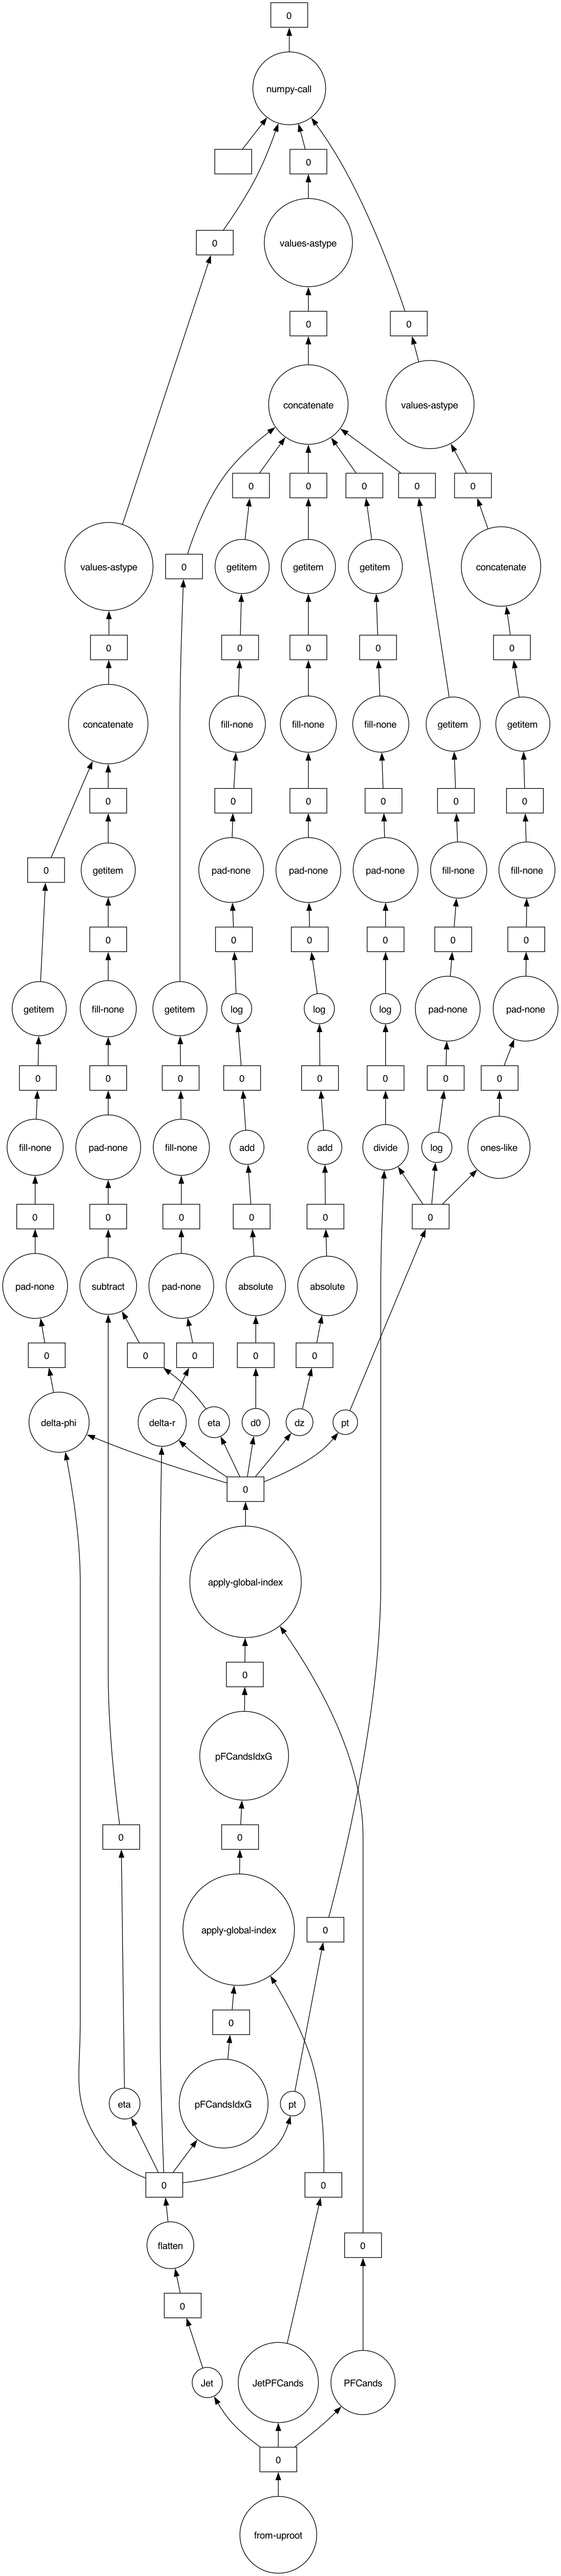

In [6]:
print(dask_results.dask)
dask_results.visualize(optimize_graph=False)

Or a peek at the optimized results:

/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/ml_tools/helper.py:175: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")


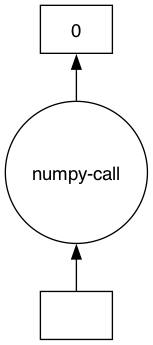

In [7]:
dask_results.visualize(optimize_graph=True)

## Example using ParticleNet-like jet variable calculation using PyTorch (DNN)

In this example, we will do the same operation as shown above, but using a simple vanilla DNN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
Define the DNN
"""
class Net(nn.Module):
    def __init__(self, input_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_shape, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        self.output = nn.Linear(32, 1)

    def forward(self, features):
        x = features
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.tanh(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = F.tanh(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = F.tanh(x)
        x = self.dropout3(x)

        x = self.output(x)
        output = F.sigmoid(x)
        return output

In [9]:
"""
Initialize and save the DNN. Normally, we would first train the DNN before saving.
"""
n_feat = 5
dummy_integer = 100
model = Net(n_feat)
model.eval()  # put in eval mode for BatchNorm1d and Dropout
input_arr = torch.rand(dummy_integer, n_feat)  # intialize a dummy input to generate torch graph for torch.jit to trace
torch.jit.trace(model, input_arr).save("test_model.pt")

In [10]:
from coffea.ml_tools.torch_wrapper import torch_wrapper


def open_events():
    factory = NanoEventsFactory.from_root(
        {"file:./pfnano.root": "Events"},
        schemaclass=PFNanoAODSchema,
        mode="dask",
    )
    return factory.events()


class DNNWrapper(torch_wrapper):
    def prepare_awkward(self, arr):
        # The input is any awkward array with matching dimension
        # Last time we added our input in a dictionary, but with a simple DNN, just add it to a list
        return [
            ak.values_astype(arr, "float32"),  # only modification we do is is force float32
        ], {}


events = open_events()
input = ak.concatenate(  # Fold 5 event-level variables into a singular array
    [
        events.event[:, np.newaxis],
        events.MET.sumEt[:, np.newaxis],
        events.MET.significance[:, np.newaxis],
        events.event[:, np.newaxis],
        events.event[:, np.newaxis],
    ],
    axis=1,
)
dwrap = DNNWrapper("test_model.pt")
output = dwrap(input)
print(output)  # This is the lazy evaluated dask array! Use this directly for histogram filling
print(f"coffea DNN output: {output.compute()}")  # Eagerly evaluated resut

/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_genPartIdx => GenPart
  warnings.warn(
/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(
/Users/iason/Dropbox/work/pyhep_dev/coffea/src/coffea/ml_tools/helper.py:175: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")


dask.awkward<numpy-call-DNNWrapper, type='## * 1 * float32', npartitions=1>
coffea DNN output: [[0.555], [0.555], [0.555], [0.555], ..., [0.555], [0.555], [0.555], [0.555]]


In [11]:
"""
Sanity check that the DNN wrapper is giving the same outputs
"""
test_input = torch.from_numpy(ak.to_numpy(input.compute())).float()
print(f"normal DNN output: {model(test_input).detach().numpy()}")

normal DNN output: [[0.5547737]
 [0.5547737]
 [0.5547737]
 [0.5547737]
 [0.5547737]
 [0.5547737]
 [0.5547737]
 [0.5547737]
 [0.5547737]
 [0.5547737]]


## Comments about generalizing to other ML tools

All ML wrappers provided in the `coffea.mltools` module (`triton_wrapper` for
[triton][triton] server inference, `torch_wrapper` for pytorch,
`xgboost_wrapper` for [xgboost][xgboost] inference, `tf_wrapper` for tensorflow) 
follow the same design: analyzers is responsible for providing the model of 
interest, along with providing an inherited class that overloads of the following
methods to data type conversion:

- `prepare_awkward`: converting awkward arrays to `numpy`-compatible awkward
  arrays, the output arrays should be in the format of a tuple `a` and a
  dictionary `b`, which can be expanded out to the input of the ML tool like
  `model(*a, **b)`. Notice some additional trivial conversion, such as the
  conversion to available kernels for `pytorch`, converting to a matrix format
  for `xgboost`, and slice of array for `triton` is handled automatically by the
  respective wrappers.
- `postprocess_awkward` (optional): converting the trivial converted numpy array
  results back to the analysis specific format. If this is not provided, then a
  simple `ak.from_numpy` conversion results is returned.

If the ML tool of choice for your analysis has not been implemented by the
`coffea.mltools` modules, consider constructing your own with the provided
`numpy_call_wrapper` base class in `coffea.mltools`. Aside from the functions
listed above, you will also need to provide the `numpy_call` method to perform
any additional data format conversions, and call the ML tool of choice. If you
think your implementation is general, also consider submitting a PR to the
`coffea` repository!

[triton]: https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver
[xgboost]: https://xgboost.readthedocs.io/en/stable/


## Additional comments on common `prepare_awkward` patterns

The key requirement of all wrapper classes in `ml_tools` package, is that to convert
awkward arrays into `numpy`-compatible formats using just `awkward` related tools, 
which ensures that no eager data conversion is performed on dask arrays. Below are
some common patterns that are useful when defining a user-level class.

### Casting multiple fields a collection to be separate axis

Given our collection of particles of length $N$, our tool is interested in just a 
sub-set of fields is to be represented as an $N\times M$ array. You can acheive this 
using just `ak.concatenate` and dimension expansion with `np.newaxis`:

```python
fields_of_interest = ["field1", "field2", "field3"]
part_np_array = ak.concatenate(
    [
        part[field][:,np.newaxis] # Expanding length N array to Nx1
        for field in fields_of_interest
    ],
    axis=1,
) # This should now be a Nx3 array
```

### Fixing collection dimensions

Many ML inteference tools work with fixed dimension inputs, with missing entries 
being set to a placeholder values. A common method for achieving this in awkward
is with `pad_none`/`fill_none` calls, for example to pad the number of particles
passed to the inference tool in each event to be a fixed length of 128:

```python
part_padded = ak.fill_none(
    ak.pad_none(part, 128, axis=1, clip=True),
    -1000, # Placeholder value
    axis=1,
)
```

The dimensions of this resulting `part_padded` array is still `N x var`, indicating
that the number of entries `axis=1` can potentially be variable. Depending on the 
ML tools being used, this axis dimension may to be fixed. To strictly convert this 
to a `Nx128` array, one can call `flatten`/`unflatten` pairs:

```python
part_padded = ak.flatten(part_padded)
part_padded = ak.unflatten(part_padded, 128) # Now this is a Nx128 array
```

### Length-zero arrays

In HEP analysis, a common routine will have you working with length-zero array in
individual chunks (ex. when running the primarly selection workflow for background
events). In these cases, you need to make sure the inference library that you are 
using behaves as expected when processing length-zero arrays. Ideally, all the
upstream librarys should handle length-zero arrays correct, but in the edges cases
where your model using a more exotic functions is causing issues, the wrappings in the
`ml_tools` package has some mechanisms that can help handle such situations:

- `tf_wrapper/tensorflow`: the `skip_length_zero` flag can be passed to the `tf_wrapper` 
  constructor. When this is set to `True`, when a length-0 array is detected to be the input, 
  the wrapper will generate a length 0 numpy array instead of attempting to pass the 
  input for inference.
- `torch_wrapper/pytorch`: as the output format of `pytorch` models is difficult to 
  implement detect at runtime without additional input, if you need to skip length-zero
  inputs, the analyist must provide the shape of the output in the `expected_output_shape` 
  argument of the the `torch_wrapper` constructor. Notice that the shape should be in 
  the format of the `numpy.array.shape` output of nominal return values, with the first
  argument substituted to be a `None` to indicate arbitrary lenght.
- `triton_wrapper/triton`: Length-zero is handled automatically by the internal batching
  process. No additional user input is required.
- `xgboost_wrapper/xgboost`: Length-zero should always be handled by the underlying 
  `xgboost` library. No additional user input is required.


